In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('default')
warnings.filterwarnings("ignore")


In [2]:
target_pairs = pd.read_csv("../data/target_pairs.csv")
train_labels = pd.read_csv("../data/train_labels.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test_labels_lag_1 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_1.csv")
test_labels_lag_2 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_2.csv")
test_labels_lag_3 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_3.csv")
test_labels_lag_4 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_4.csv")

In [3]:
df = train.copy()

# Show first 5 rows
print("🔹 First 5 rows:")
display(df.head())

# Shape of the dataset
print(f"\n🔹 Dataset shape: {df.shape}")

# Column info
print("\n🔹 Column info:")
df.info()

# Missing values
print("\n🔹 Missing values per column:")
print(df.isnull().sum())

# Basic stats
print("\n🔹 Statistical summary:")
display(df.describe())

# Quick correlation heatmap (only for numerical columns)
# plt.figure(figsize=(10,6))
# sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm', fmt='.2f')
# plt.title("Correlation Heatmap")
# plt.show()


🔹 First 5 rows:


,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
0,0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037
3,3,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,1.683111,0.785329,0.889439,0.698502,0.067639,0.091558,0.121021,0.079285,14.035571,0.059983
4,4,2175.0,7125.0,2604.0,3386.0,NaN,NaN,NaN,NaN,NaN,...,1.684816,0.787264,0.891042,0.701485,0.067443,0.091266,0.121055,0.078925,14.013760,0.059503



🔹 Dataset shape: (1961, 558)

🔹 Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Columns: 558 entries, date_id to FX_ZARGBP
dtypes: float64(557), int64(1)
memory usage: 8.3 MB

🔹 Missing values per column:
date_id          0
LME_AH_Close    51
LME_CA_Close    51
LME_PB_Close    51
LME_ZS_Close    51
                ..
FX_NOKGBP        0
FX_NOKCHF        0
FX_ZARCHF        0
FX_NOKJPY        0
FX_ZARGBP        0
Length: 558, dtype: int64

🔹 Statistical summary:


,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
count,1961.000000,1910.000000,1910.000000,1910.000000,1910.000000,1845.000000,1845.000000,1845.000000,1845.000000,1845.000000,...,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000,1961.000000
mean,980.000000,2252.202853,7928.229026,2085.848576,2795.022628,7693.877507,7758.334417,7694.050407,3792.407046,3793.646070,...,1.710787,0.703105,0.856095,0.602847,0.056007,0.082366,0.099372,0.058701,13.096718,0.048583
std,566.236258,398.544566,1523.186335,183.154551,445.009643,3062.235504,3127.499852,3062.510197,721.833890,723.465805,...,0.067369,0.049470,0.036205,0.059288,0.005752,0.007005,0.013947,0.009828,0.969003,0.005338
min,0.000000,1462.000000,4630.000000,1585.500000,1815.500000,4171.000000,4216.000000,4171.000000,2200.000000,2164.000000,...,1.472061,0.579407,0.767636,0.466372,0.045552,0.069614,0.076132,0.042087,9.618859,0.039464
25%,490.000000,1925.250000,6396.125000,1973.000000,2479.500000,5197.000000,5210.000000,5197.000000,3160.000000,3156.000000,...,1.684365,0.663481,0.825814,0.546662,0.050591,0.074915,0.084064,0.048954,12.546578,0.043391
50%,980.000000,2245.500000,8260.750000,2070.750000,2771.000000,6622.000000,6659.000000,6619.000000,3802.500000,3803.000000,...,1.713406,0.719225,0.853417,0.615227,0.056036,0.083721,0.101440,0.058030,13.266953,0.048661
75%,1470.000000,2512.000000,9323.375000,2188.000000,3031.000000,8947.500000,8975.000000,8946.000000,4326.000000,4329.000000,...,1.743424,0.744981,0.883287,0.649179,0.060573,0.087033,0.109417,0.066195,13.808442,0.052472
max,1960.000000,3849.000000,10889.000000,2681.000000,4498.500000,16270.000000,16400.000000,16277.000000,6272.500000,6280.000000,...,1.881218,0.788635,0.950091,0.710020,0.070469,0.094472,0.125403,0.081612,15.314668,0.062025


In [4]:
def create_exchange_dataframes(train):
    lme_cols = []
    jpx_cols = []
    fx_cols = []
    us_cols = []
    for col in train.columns:
        if col.endswith('_Close') or col.endswith('_close'):
            if col.startswith('LME'):
                lme_cols.append(col)
            elif col.startswith('JPX'):
                jpx_cols.append(col)
            elif col.startswith('US'):
                us_cols.append(col)
        if col.startswith('FX'):
            fx_cols.append(col)

    exchanges_data = {
        'US': pd.DataFrame(),
        'LME': pd.DataFrame(),
        'FX': pd.DataFrame(),
        'JPX': pd.DataFrame()
    }
    
    
    if lme_cols:
        exchanges_data['LME'] = train[lme_cols]
    if jpx_cols:
        exchanges_data['JPX'] = train[jpx_cols]
    if fx_cols:
        exchanges_data['FX'] = train[fx_cols]
    if us_cols:
        exchanges_data['US'] = train[us_cols]

    return exchanges_data

EXCHANGES = create_exchange_dataframes(train)

In [5]:
def calculate_sharpe_ratio(returns):
    """
    Calculate Sharpe Ratio assuming a risk-free rate of 0.
    Annualization factor is not applied here, it's a daily Sharpe-like ratio.
    """
    if returns.std() == 0:
        return 0  # Avoid division by zero
    return returns.mean() / returns.std()

def evaluate_model(model, X_train, y_train, X_test, y_test, target_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Calculate Sharpe-like ratios
    # Assuming y_test and predictions represent returns or changes in value
    actual_returns = pd.Series(y_test).diff().dropna() # Use diff to get daily returns from target values
    predicted_returns = pd.Series(predictions).diff().dropna() # Use diff to get daily returns from predicted values

    # Ensure actual_returns and predicted_returns have the same length for Sharpe calculation
    min_len = min(len(actual_returns), len(predicted_returns))
    actual_sharpe = calculate_sharpe_ratio(actual_returns.iloc[-min_len:])
    predicted_sharpe = calculate_sharpe_ratio(predicted_returns.iloc[-min_len:])

    return {
        'Commodity': target_name,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Actual_Sharpe': actual_sharpe,
        'Predicted_Sharpe': predicted_sharpe
    }

print("Sharpe ratio and evaluation functions defined.")

Sharpe ratio and evaluation functions defined.


In [6]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

def calculate_sharpe_ratio(returns):
    if returns.std() == 0:
        return 0  # Handle division by zero
    return returns.mean() / returns.std()

print("Regression models imported and calculate_sharpe_ratio function defined.")

Regression models imported and calculate_sharpe_ratio function defined.


In [7]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=50, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
}

print("Regression models instantiated and stored in 'models' dictionary.")

Regression models instantiated and stored in 'models' dictionary.


In [8]:
results_by_exchange = {}

for exchange_name, exchange_df in EXCHANGES.items():
    if exchange_df.empty: # Skip if the exchange DataFrame is empty
        continue

    exchange_commodity_data = {}
    for commodity_col in exchange_df.columns:
        # Create lagged features for the current commodity (past 5 days)
        X_features = pd.DataFrame()
        for i in range(1, 6):
            X_features[f'{commodity_col}_lag_{i}'] = exchange_df[commodity_col].shift(i)

        # Define the target variable
        y_target = exchange_df[commodity_col]

        # Combine features and target to drop NaNs synchronously
        # Ensure alignment by index (which is 'date_id' for exchange_df)
        combined_df = pd.concat([X_features, y_target], axis=1).dropna()

        if combined_df.empty:
            # print(f"Skipping {commodity_col} in {exchange_name} due to insufficient data after lagging and dropping NaNs.")
            continue

        # Separate X and y after dropping NaNs
        X_processed = combined_df.drop(columns=[commodity_col])
        y_processed = combined_df[commodity_col]

        # Perform time-series split (80/20)
        train_size = int(len(X_processed) * 0.8)

        X_train = X_processed.iloc[:train_size]
        X_test = X_processed.iloc[train_size:]
        y_train = y_processed.iloc[:train_size]
        y_test = y_processed.iloc[train_size:]

        exchange_commodity_data[commodity_col] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
    
    if exchange_commodity_data: # Only add to results_by_exchange if commodities were processed
        results_by_exchange[exchange_name] = exchange_commodity_data

print("Lagged features created and time-series split performed for all relevant commodities in each exchange.")

Lagged features created and time-series split performed for all relevant commodities in each exchange.


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

all_model_results = []

for exchange_name, exchange_commodity_data in results_by_exchange.items():
    for commodity_col, data in exchange_commodity_data.items():
        X_train = data['X_train']
        X_test = data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        actual_sharpe_ratio = calculate_sharpe_ratio(y_test.diff().dropna())

        for model_name, model in models.items():
            # Train the model
            model.fit(X_train, y_train)

            # Generate predictions
            y_pred = model.predict(X_test)

            # Ensure y_pred is a Series for Sharpe Ratio calculation
            y_pred_series = pd.Series(y_pred, index=y_test.index)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Calculate predicted Sharpe Ratio
            predicted_sharpe_ratio = calculate_sharpe_ratio(y_pred_series.diff().dropna())

            # Store results
            all_model_results.append({
                'Exchange': exchange_name,
                'Commodity': commodity_col,
                'Model': model_name,
                'MSE': mse,
                'MAE': mae,
                'R2': r2,
                'Actual_Sharpe': actual_sharpe_ratio,
                'Predicted_Sharpe': predicted_sharpe_ratio
            })

print("All models trained and performance metrics calculated for each commodity across all exchanges.")


All models trained and performance metrics calculated for each commodity across all exchanges.


In [10]:
results_df = pd.DataFrame(all_model_results)

averaged_results_by_exchange = results_df.groupby(['Exchange', 'Model'])[['MSE', 'MAE', 'R2', 'Actual_Sharpe', 'Predicted_Sharpe']].mean().reset_index()

overall_averaged_results = averaged_results_by_exchange.groupby('Model')\
    [['MSE', 'MAE', 'R2', 'Actual_Sharpe', 'Predicted_Sharpe']].mean().reset_index()

display(overall_averaged_results)

,Model,MSE,MAE,R2,Actual_Sharpe,Predicted_Sharpe
0,DecisionTreeRegressor,1.763614e+06,452.582833,-0.299456,0.044109,0.009775
1,GradientBoostingRegressor,1.841887e+06,455.565338,-0.212064,0.044109,0.017422
2,LinearRegression,4.047818e+03,27.304648,0.961321,0.044109,0.043553
3,RandomForestRegressor,1.799595e+06,451.689145,-0.234967,0.044109,0.018654
4,Ridge,4.047817e+03,27.305484,-0.594217,0.044109,0.044691


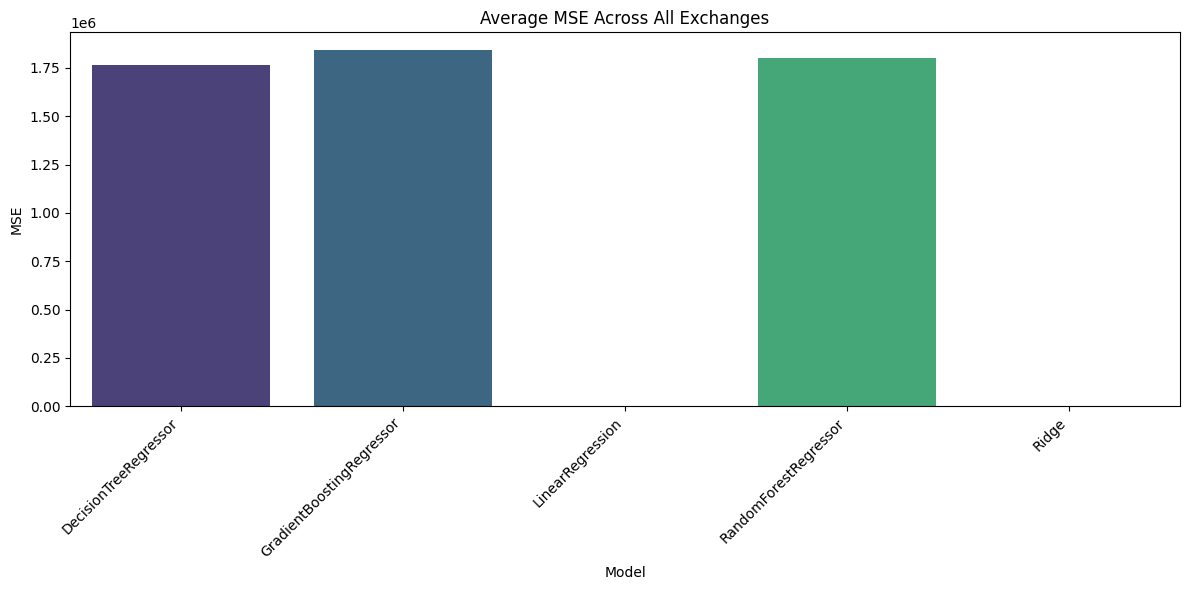

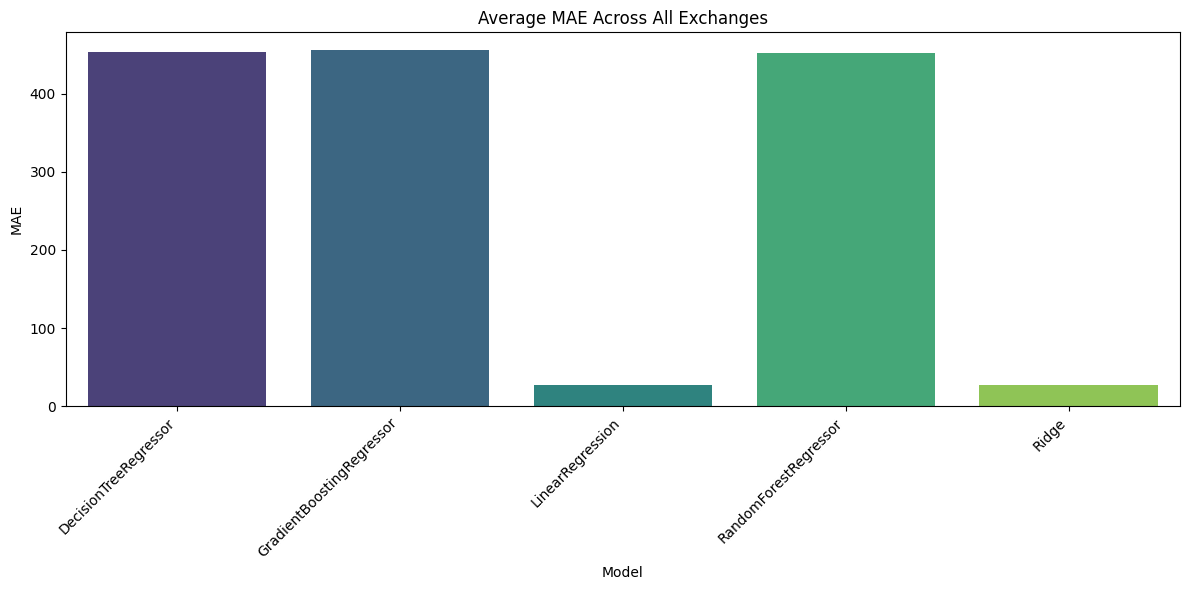

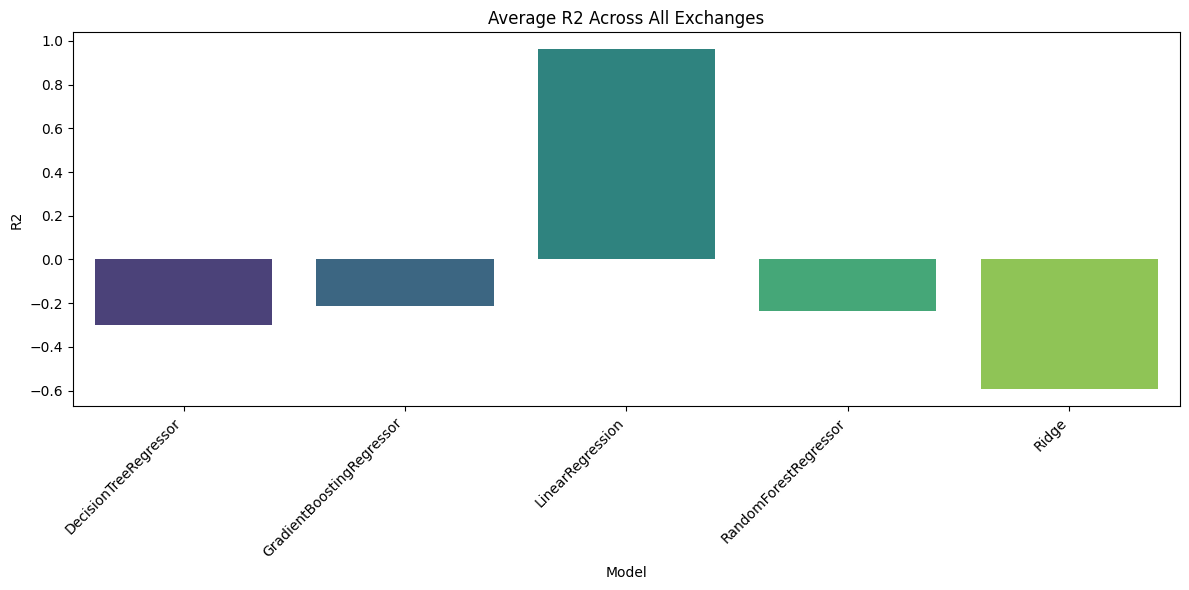

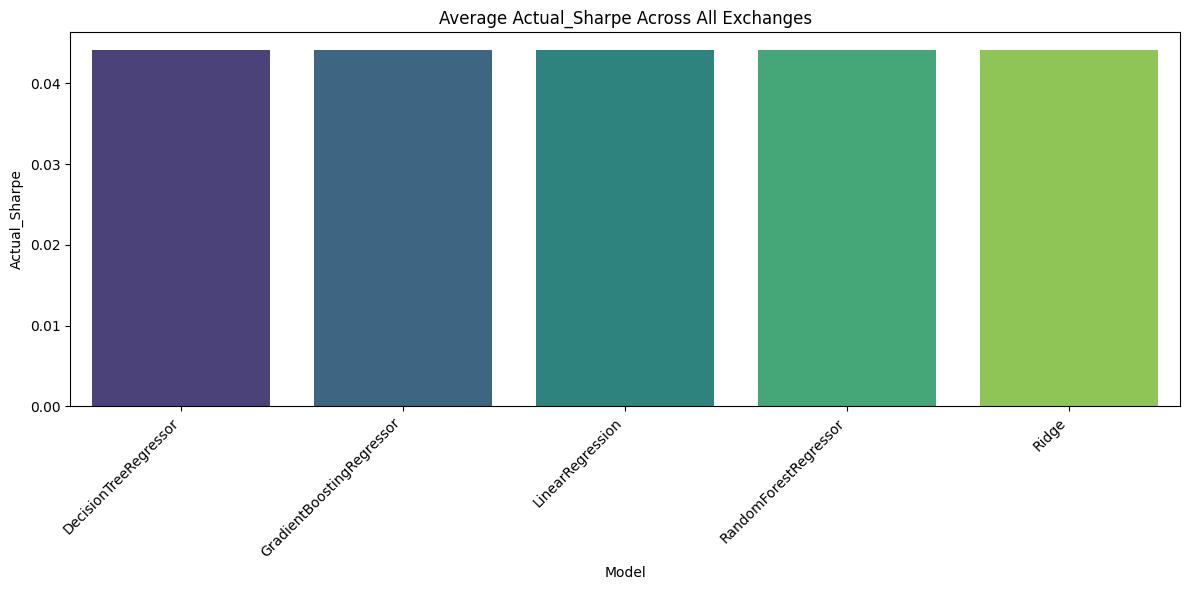

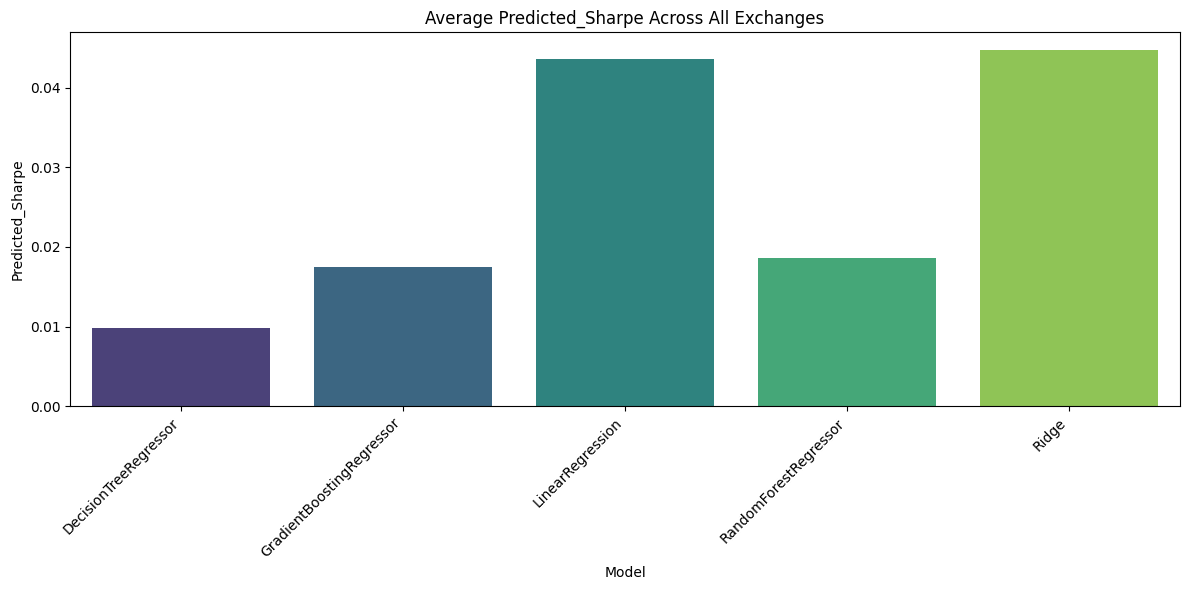

Performance plots generated and saved.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['MSE', 'MAE', 'R2', 'Actual_Sharpe', 'Predicted_Sharpe']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric, data=overall_averaged_results, palette='viridis')
    plt.title(f'Average {metric} Across All Exchanges')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # plt.savefig(f'{metric.lower()}_average_performance.png')
    plt.show()

print("Performance plots generated and saved.")

In [12]:
overall_averaged_results.to_csv('../results/baseline_averaged_results.csv', index=False)
print("Saved 'overall_averaged_results.csv'")

Saved 'overall_averaged_results.csv'


In [13]:
import json

results_by_exchange_json = json.dumps(all_model_results, indent=4, default=str)

with open('../results/baseline_results.json', 'w') as f:
    f.write(results_by_exchange_json)

print("Saved 'baseline_results.json'")

Saved 'baseline_results.json'


## Summary:

### Data Analysis Key Findings
*   **Superiority of Linear Models**: Linear Regression and Ridge Regression generally demonstrated superior performance compared to tree-based models (Decision Tree Regressor, Random Forest Regressor, and Gradient Boosting Regressor) across all evaluated exchanges for predicting commodity prices. They consistently achieved higher R-squared values and lower error metrics.
*   **High Predictive Power of Linear/Ridge Models**: For most exchanges, Linear and Ridge models exhibited strong predictive capabilities, with R-squared values frequently above 0.9. For example, Linear Regression achieved an R-squared of `0.9521` for the FX exchange, and Ridge Regression reached `0.980291` for JPX and `0.962973` for the US exchange.
*   **Poor Performance of Tree-based Models**: Decision Tree and Random Forest Regressors often showed very poor performance, indicated by significantly higher Mean Squared Error (MSE) and Mean Absolute Error (MAE), and frequently negative R-squared values. For instance, DecisionTreeRegressor on JPX had an R-squared of `-2.46908`, and on US it was `-0.183475`, suggesting they performed worse than simply predicting the mean.
*   **Variability in Sharpe Ratio Prediction**: The predicted Sharpe Ratios varied considerably among models and exchanges, sometimes being higher or lower than the actual Sharpe Ratio. This indicates inconsistent ability of the models to accurately capture risk-adjusted returns alongside price prediction.
*   **Exchange-Specific Nuances**: While Linear and Ridge models were generally best, their exact relative performance and the specific error metrics varied by exchange, highlighting the importance of evaluating models for each specific market context.

### Insights or Next Steps
*   Given the strong performance of Linear and Ridge Regression, focus on refining these models, potentially exploring regularization strengths or incorporating more advanced linear features.
*   Investigate the reasons behind the poor performance of tree-based models, such as potential overfitting, lack of suitable hyperparameters, or their inherent difficulty in handling time-series dependencies with simple lagged features compared to linear relationships.



In [14]:
models

{'LinearRegression': LinearRegression(),
 'Ridge': Ridge(random_state=42),
 'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
 'RandomForestRegressor': RandomForestRegressor(n_estimators=50, random_state=42),
 'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)}

In [15]:
import joblib

In [16]:
for i in models:
    joblib.dump(i, f"../models/{i}.pkl")